In [63]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn import metrics
import matplotlib.pyplot as plt
import math
import random
import datetime as dt
import glob
import seaborn as sns
from scipy import stats
from pylab import figure, scatter, show
from matplotlib import colors

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

In [2]:
allFiles = glob.glob("*.csv")
frame = pd.DataFrame()
list_ = []

for file_ in allFiles:
    num_lines = sum(1 for l in open(file_))
    # Sample size - in this case ~1%
    size = int(num_lines / 100)

    skip_idx = random.sample(range(1, num_lines), num_lines - size)

    df = pd.read_csv(file_, skiprows=skip_idx, index_col=None, header=0 )
    list_.append(df)
    
yellow = pd.concat(list_)

In [3]:
yellow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292360 entries, 0 to 92846
Data columns (total 17 columns):
VendorID                 292360 non-null int64
tpep_pickup_datetime     292360 non-null object
tpep_dropoff_datetime    292360 non-null object
passenger_count          292360 non-null int64
trip_distance            292360 non-null float64
RatecodeID               292360 non-null int64
store_and_fwd_flag       292360 non-null object
PULocationID             292360 non-null int64
DOLocationID             292360 non-null int64
payment_type             292360 non-null int64
fare_amount              292360 non-null float64
extra                    292360 non-null float64
mta_tax                  292360 non-null float64
tip_amount               292360 non-null float64
tolls_amount             292360 non-null float64
improvement_surcharge    292360 non-null float64
total_amount             292360 non-null float64
dtypes: float64(8), int64(6), object(3)
memory usage: 40.1+ MB


In [5]:
data = yellow[(yellow['passenger_count'] < 10) & 
                        (yellow['passenger_count'] > 0) & 
                        (yellow['extra'] >= 0) &
                        (yellow['extra'] <= 1) &
                        (yellow['RatecodeID'] < 7) &
                        (yellow['trip_distance'] > 0) &
                        (yellow['mta_tax'] >= 0) &
                        (yellow['tip_amount'] >= 0) &
                        (yellow['tolls_amount'] >= 0) &
                        (yellow['improvement_surcharge'] > 0) &
                        (yellow['total_amount'] > 0)]

data = data.replace({'store_and_fwd_flag': {'Y': 1, 'N': 0}})

data['tpep_pickup_datetime'] = data.tpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['tpep_dropoff_datetime'] = data.tpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

data['pickup_hour'] = data.tpep_pickup_datetime.apply(lambda x: x.hour)
data['pickup_day'] = data.tpep_pickup_datetime.apply(lambda x: x.weekday())
data = data.assign(duration = lambda x: ((x.tpep_dropoff_datetime-x.tpep_pickup_datetime)/ np.timedelta64(1, 'm')))
data = data.assign(before_tip = lambda x: (x.total_amount-x.tip_amount))


In [272]:
tip_data = data[(data['payment_type'] == 1)]

In [273]:
tip_data = tip_data.assign(tip_percentage_2 = lambda x: (x.tip_amount/(x.before_tip))*100)
tip_data['tip_no_paid'] = tip_data.tip_amount.isin([0]).astype(np.int64)
tip_data = tip_data[(tip_data['tip_no_paid'] == 0)]

In [299]:
tip_data = tip_data[(np.abs(stats.zscore(tip_data[['tip_amount','before_tip']])) < 3).all(axis=1)]


In [331]:
df = tip_data.iloc[random.sample(range(len(tip_data)),10000),]

In [332]:
x = pd.DataFrame({'x':(df['before_tip'].reset_index())['before_tip']})
y = (df['tip_amount'].values)
y = y[:,None]

In [333]:
class DecisionTree():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [334]:
def std_agg(cnt, s1, s2): return math.sqrt(abs((s2/cnt) - (s1/cnt)**2))


In [335]:
x.shape, y.shape, x.index

((10000, 1), (10000, 1), RangeIndex(start=0, stop=10000, step=1))

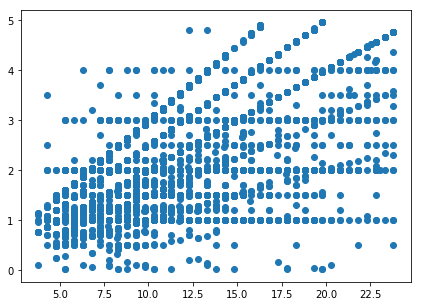

In [336]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')

In [ ]:
xi = x # initialization of input
yi = y # initialization of target
# x,y --> use where no need to change original y
ei = 0 # initialization of error
n = len(yi)  # number of rows
predf = 0 # initial prediction 0

for i in range(80): # like n_estimators
    tree = DecisionTree(xi,yi)
    tree.find_better_split(0)  # For selected input variable, this splits (<n and >n) data so that std. deviation of 
                               # target variable in both splits is minimum as compared to all other splits
    
    r = np.where(xi == tree.split)[0][0]    #  finds index where this best split occurs
    
    left_idx = np.where(xi <= tree.split)[0]   # index lhs of split
    right_idx = np.where(xi > tree.split)[0]   # index rhs of split
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  # replace left side mean y
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))  # right side mean y
    
    predi = predi[:,None]  # make long vector (nx1) in compatible with y
    predf = predf + predi  # final prediction will be previous prediction value + new prediction of residual
    
    ei = y - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop
    
    
    # plotting after prediction
    xa = np.array(x.x) # column name of x is x 
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    #epreds = np.array(epred[:,None])[order]
    if i >70 :
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

        ax1.plot(x,y, 'o')
        ax1.plot(xs, ys, 'r')
        ax1.set_title(f'Prediction (Iteration {i+1})')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y / y_pred')

        ax2.plot(x, ei, 'go')
        ax2.set_title(f'Residuals vs. x (Iteration {i+1})')
        ax2.set_xlabel('x')
        ax2.set_ylabel('Residuals')
    else: pass